#### Recepção AM-DSB-SC (detecção coerente) 
Demodular um sinal AM-DSB-SC em termos de código é extremamente simples, visto que basta devolver a portadora ao sinal enviado multiplicando os dois e em seguida um filtro passa-baixa que teremos o sinal $m(t)$.

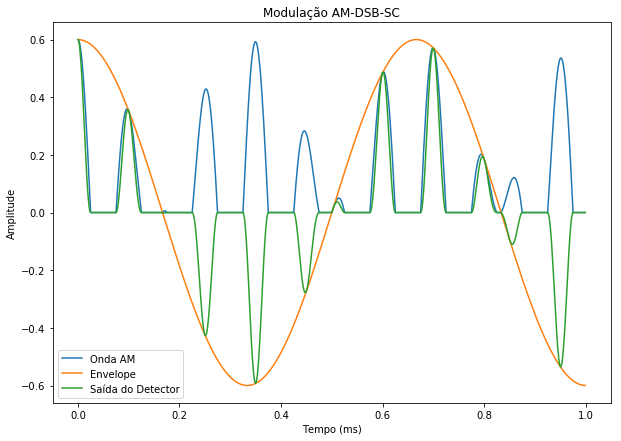

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import fftpack

Ts = 1e-6
t = np.arange(1000)*Ts
fc = 10000                                                  # Frequencia da portadora.
fm = 1500                                                   # Frequencia do sinal
tau = 3e-5                                                  # Constante de tempo do detector de envelope.
Mu = 0.6                                                    # Indice de modulaçao.
x_AM = Mu*np.cos(2*np.pi*fm*t)*np.cos(2*np.pi*fc*t);                   # Onda Modulada AM-DSB-SC
x_env1 = Mu*np.cos(2*np.pi*fm*t) #envelope ideal
x_AM = x_AM*(x_AM>0)
x_env= np.zeros(len(x_AM))
#cálculo da saída
x_env = x_AM*np.cos(2*np.pi*fc*t)

plt.figure(1,[10,7])
sinal_AM = plt.plot(t*1000,x_AM)
envelope_ideal = plt.plot(1000*t,x_env1)
detector = plt.plot(t*1000,x_env)
plt.legend(["Onda AM","Envelope","Saída do Detector"])
plt.xlabel("Tempo (ms)")
plt.ylabel("Amplitude")
plt.title("Modulação AM-DSB-SC")
plt.show()

Porém em termos práticos há um custo muito elevado de se gerar um sinal da portadora em fase com o sinal recebido, não sendo apropriado para sistemas de difusão e sim pra transmissão ponto a ponto (mesmo numero de transmissores e receptores). 

### AM-SSB  
#### Sinal no tempo e frequência 

Na modulação AM formam-se duas bandas laterais, como já comentado anteriormente, que possuem a informação completa do sinal $m(t)$. Em consequência, para um sinal em banda base, a modulação AM-DSB requer o dobro de largura de banda necessário para a transmissão. Para melhorar a eficiência espectral de banda, bem como a de potência de transmissão, basta transmitir uma delas e filtrando a outra, resultando num novo tipo de transmissão AM-SSB. Além disso, podemos remover a portadora do sinal, resultando na AM-DSB-SC. A demodulação do sinal AM-SSB-SC é exatamente a mesma de um sinal AM-DSB-SC. A grande vantagem da AM-SSB-SC está na economia de até 83% da potência de transmissão, embora sejam necessários osciladores tão precisos quanto os da AM-DSB-SC.

No script abaixo, é exemplificado o processo de modulação e demodulação da AM-SSB. Inicialmente modula-se a onda AM em DSB-SC e em seguida é feita a filtragem de frequências superiores (LSB) ou inferiores (USB) da onda DSB, formando AM-SSB.

In [19]:
Ts=1e-4                                                    # Período de amostragem
fs=1/Ts                                                    # Frequencia de amostragem
t = np.arange(5e3)*Ts                                            # Definição do vetor tempo
fc = 500                                                   # Frequencia da portadora.
fm = 150                                                   # Frequencia do sinal
Am=1.0                                                       # Amplitude do sinal senoidal
Ac=1.0                                                       # Amplitude da portadora
Mu = Am/Ac                                                 # Indice de modulaçao.
carrier = Ac*np.cos(2*np.pi*fc*t)                                # Sinal portadora
m_t = Am*np.cos(2*np.pi*fm*t)*np.exp(-t*20)                        # Sinal mensagem
lmt = len(m_t)                                          # Comprimento do vetor mensagem
M_t = 2.0*np.abs(fftpack.fftshift(fftpack.fft(m_t,lmt)))/lmt          # Sinal na frequência
freq_m = np.arange(-fs/2,fs/2,fs/lmt)                  # Eixo da frequência para M_t

# Modulação SSB
# Modulação DSB-SC
x_AM = m_t*carrier                                        # Onda Modulada DSB-SC no tempo
lfft = len(x_AM)                                        # Comprimento do sinal DSB-SC
lfft = int(2**np.ceil(np.log2(lfft)))                                 # Comprimento do sinal DSB-SC potência de dois ex(1001 --> 1024)
X_AM = 2.0*np.abs(fftpack.fftshift(fftpack.fft(x_AM,lfft)))/lfft #Onda Modulada AM-DSB-SC na Frequência
freq = np.arange(-fs/2,fs/2,fs/lfft)                    # Eixo da frequência 
L_lsb = int(np.floor(fc*Ts*lfft))                       # Local na frequência que se encontra a LSB.

#filtragem da LSB
Filt_LSB = np.ones(lfft)                                    #Vetor filtro LSB (degrau) na frequencia 
Filt_LSB[lfft//2-L_lsb:lfft//2+L_lsb] = np.zeros(2*L_lsb)   # Definindo zeros na LSB
X_SSB_USB = X_AM*Filt_LSB                                 # Filtrando a frequência LSB

#filtragem da USB
Filt_USB = np.zeros(lfft)                                    #Vetor filtro USB na frequencia  
Filt_USB[lfft//2-L_lsb:lfft//2+L_lsb] = np.ones(2*L_lsb)   # DOnde tinha 1 agora tem 0
X_SSB_LSB = X_AM*Filt_USB                                 # Filtrando a frequência USB

#filtragem da USB
## Visualização SSB no tempo
# USB tempo
s_ssb_USB = np.real(fftpack.ifft(fftpack.fftshift(X_SSB_USB)))        # Inversa de fourrier
s_ssb_USB = s_ssb_USB[1:lmt]                      # Ajustando o comprimento do vetor

# LSB tempo
s_ssb_LSB =  np.real(fftpack.ifft(fftpack.fftshift(X_SSB_LSB)))     # Inversa de fourrier
s_ssb_LSB = s_ssb_LSB[1:lmt]                  # Ajustando o comprimento do vetor

# Demodulação
# Demodulação SSB-USB
from scipy import signal

s_dem_USB= s_ssb_USB*carrier*2                            # Multiplicação com a portadora em fase
B_m=1000                                                   # Banda para filtragem 
h=signal.firwin(50,B_m*Ts)                                  # Janelamento Hamming da banda
#s_rec_USB=filter(h,1e-4,s_dem_USB);                         # Sinal filtrado
#o que a filter faz?
lfft=len(s_rec_USB)                                     # Comprimento do sinal recuperado
lfft=2^ceil(log2(lfft))                                    # Transformando para uma potencia de 2
SSB_freq_USB = fftpack.fftshift(fftpack.fft(s_rec_USB,lfft)/lfft)          # Sinal recuperado na frequencia
s_rec_USB = (max(m_t)/max(s_rec_USB))*s_rec_USB            # Amplificando o sinal

# Demodulação SSB-LSB
s_dem_LSB= s_ssb_LSB*carrier*2;                            # Multiplicação com a portadora em fase
B_m=1000                                                   # Banda para filtragem 
h=signal.firwin(50,B_m*Ts)                              # Janelamento Hamming da banda
#s_rec_LSB =filter(h,1e-4,s_dem_LSB);                         # Sinal filtrado

lfft=len(s_rec_LSB)                                     # Comprimento do sinal recuperado
lfft=2^ceil(log2(lfft))                                    # Transformando para uma potencia de 2
SSB_freq_LSB = fftpack.fftshift(fftpack.fft(s_rec_LSB,lfft)/lfft)          # Sinal recuperado na frequencia
s_rec_LSB = (max(m_t)/max(s_rec_LSB))*s_rec_LSB            # Amplificando o sinal
